In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray
import matplotlib.pyplot as plt
from shapely.geometry import box
from scipy.signal import savgol_filter
import rasterio
from rasterio.features import rasterize
from osgeo import gdal
import rioxarray
import traceback

from func_processing import ts_telcirkel_per_jaar, bare_soil_calc, bare_soil_format


## Settings


In [17]:
vi_str = 'bsi' # van welke vegetatie-index analyse doen?

output_folder = 'Q:/Projects/PRJ_MBAG/4d_bwk/project-telcirkels/rasters-telcirkels-mas-v2' #folder location of the rasters

path_2022 = 'Q:/Projects/PRJ_MBAG/4d_bwk/project-telcirkels/landbouwgebruikspercelen_cut_bo_2022_clip_v2.gpkg'
path_2023 = 'Q:/Projects/PRJ_MBAG/4d_bwk/project-telcirkels/landbouwgebruikspercelen_cut_bo_2023_clip_v2.gpkg'
path_2024 = 'Q:/Projects/PRJ_MBAG/4d_bwk/project-telcirkels/landbouwgebruikspercelen_cut_bo_2024_clip_v2.gpkg'


In [6]:

#---- 
# Reading in all the parcels from Z-/Q-schijf and combining into one 
gdf_2022 = gpd.read_file(path_2022).to_crs(32631)
gdf_2023 = gpd.read_file(path_2023).to_crs(32631)
gdf_2024 = gpd.read_file(path_2024).to_crs(32631)

#----

# Dictionary met de geodataframes per jaar (aanpassen als je meer of minder jaren wilt, moet natuurlijk binnen het tijdsbereik waarvoor er rasters gedownload zijn)
analysis_years_dict = {2022: gdf_2022, 2023: gdf_2023, 2024: gdf_2024}

# Dictionary met de telperiodes (hard-coded...)
periods = {
'R1_2022': ('2022-04-01', '2022-04-20'),
'R2_2022': ('2022-04-21', '2022-05-10'),
'R3_2022': ('2022-05-11', '2022-06-10'),
'R4_2022': ('2022-06-21', '2022-07-15'),
'R1_2023': ('2023-04-01', '2023-04-20'),
'R2_2023': ('2023-04-21', '2023-05-10'),
'R3_2023': ('2023-05-11', '2023-06-10'),
'R4_2023': ('2023-06-21', '2023-07-15'),
'R1_2024': ('2024-04-01', '2024-04-20'),
'R2_2024': ('2024-04-21', '2024-05-10'),
'R3_2024': ('2024-05-11', '2024-06-10'),
'R4_2024': ('2024-06-21', '2024-07-15')}

## Bare soil analysis
Eerst de weggeschreven rasters terug inladen op de juiste manier (time index valt onder andere weg blijkbaar). Daarna op de ingeladen data de *bare soil analysis* doen. De analyse op de weggeschreven rasters doen gaat veel sneller dan het rechtstreeks uit te voeren wanneer de data van earth engine komt! De *bare soil analysis* moet per jaar apart gebeuren met de bijbehorende landbouwgebruikspercelen, terwijl de rasters gedownload zijn voor verschillenden jaren tegelijk. In deze analyse moet dus andere polygonen gebruikt worden afhankelijk van het jaar.

<Axes: >

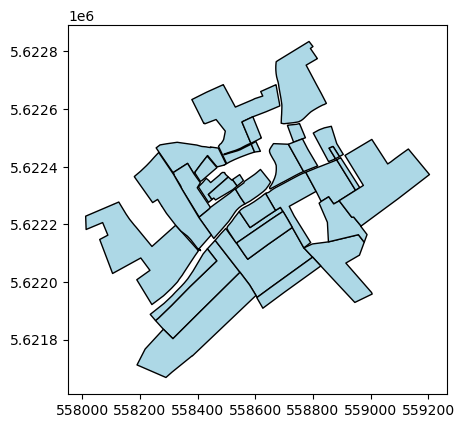

In [ ]:
gdf_2022.head(5)


# CRS should be 4326
gdf_2022.loc[(gdf_2022.pointid == 'Lm_11070')].plot(color='lightblue', edgecolor='black', linewidth=1)

In [11]:
#-- Aggregation of time series over polygons

# Definieer de 10-daagse periodes (Maand-Dag)
# Deze worden automatisch gecombineerd met het juiste jaar (2022, 2023, etc.)
base_dates_md = [
    '02-01', '02-11', '02-21', '03-03', '03-13', '03-23', 
    '04-02', '04-12', '04-22', '05-02', '05-12', '05-22',
    '06-01', '06-11', '06-21', '07-01', '07-11', '07-21', 
    '07-31', '08-10', '08-20', '08-30'
]


# Create empty dataframe for storage results (polygon-aggregated time series)
df_ts = pd.DataFrame(columns=['REF_ID', 'pointid', 'time', vi_str])

# --- Use os.walk to go though year subfolders---
print(f"Start verwerking van bestanden in {output_folder}...")
all_raster_files = []
# os.walk doorloopt de hoofdmap én alle submappen
for dirpath, dirnames, filenames in os.walk(output_folder):
    for filename in filenames:
        # Check of het een relevant rasterbestand is
        if (vi_str in filename) and (filename.endswith('_sg.tif')):
            
            # Sla het volledige pad en het jaar (de mapnaam) op
            full_path = os.path.join(dirpath, filename)
            year_str = os.path.basename(dirpath) # Dit pakt de mapnaam, bv. '2022'
            all_raster_files.append((full_path, year_str))

print(f"{len(all_raster_files)} rasterbestanden gevonden.")

# --- Loop nu door de gevonden bestanden ---
for full_path, year_str in all_raster_files:
    
    try:
        # --- STAP A: Bepaal jaar, pointid, GDF en datums ---
        
        # 1. Converteer mapnaam naar jaar-getal
        year = int(year_str)
        
        # 2. Haal pointid uit de bestandsnaam
        # GAAT UIT VAN EEN NAAM ALS: 'multiband_raster_bsi_Lm_11070_sg.tif'
        filename = os.path.basename(full_path)
        parts = filename.replace('_sg.tif', '').split('_')
        # Check of 'parts[4]' (het tweede deel van de ID) wel bestaat.
        # # Een lijst met 5 items (0,1,2,3,4) heeft een index 4.
        if len(parts) > 4:
            # Zo ja: combineer deel 3 en 4 (bv. 'Lm_11070')
            pointid = parts[3] + '_' + parts[4]
        else:
            # Zo niet: gebruik alleen deel 3 (bv. 'Lm11070')
            pointid = parts[3]

        
        # 3. Pak de juiste landbouwpercelen GDF voor dit jaar
        if year not in analysis_years_dict:
            print(f"  > Warning: Jaar {year} (uit map {year_str}) niet gevonden in 'analysis_years_dict'. Bestand {filename} overgeslagen.")
            continue
        gdf_year = analysis_years_dict[year]

        # 4. Genereer de datumlijst voor dit specifieke jaar
        # # Combineer het 'year' (bv. 2022) met de 'base_dates_md' (bv. '02-01')
        date_strings_for_year = [f"{year}-{md}" for md in base_dates_md]
        time_index = pd.to_datetime(date_strings_for_year)

        # --- STAP B: Open raster en voeg handmatig datums toe ---
        raster = rioxarray.open_rasterio(full_path)

        # 5. Controleer of het aantal banden overeenkomt met je datumlijst
        if len(time_index) != raster.band.size:
            print(f"  > ERROR: Aantal datums ({len(time_index)}) komt niet overeen "
                  f"met aantal banden ({raster.band.size}) in {filename}. BESTAND OVERGESLAGEN.")
            continue
        
        # 6. WIJS DE DATUMS TOE (DE FIX VOOR HET "NIET OPGESLAGEN" PROBLEEM)
        raster['band'] = time_index

        # --- STAP C: Verwerk de data (je oude logica) ---
        raster = raster.rename({'band': 'time', 'x' : 'X', 'y': 'Y'}).transpose('time', 'X', 'Y')
        raster = raster.rio.set_spatial_dims('X','Y')
        raster.rio.write_crs("EPSG:32631", inplace=True)

        # --- STAP D: Roep je analysefunctie aan ---
        # We roepen dit nu maar 1x per bestand aan (niet meer in een geneste loop)
        print(f"  > Verwerk {filename} (pointid: {pointid}, jaar: {year})")
        df_ts = ts_telcirkel_per_jaar(raster=raster, gdf=gdf_year, year=year, pointid=pointid, df_ts=df_ts)

    except Exception as e:
        print(f"  > FATALE FOUT bij verwerken {filename}: {e}")
        traceback.print_exc()

# --- STAP E: Sla de resultaten op (deze code is ongewijzigd) ---
print("Alle bestanden zijn verwerkt. Resultaten sorteren en opslaan...")
df_ts = df_ts.sort_values(by = ['pointid','REF_ID','time']).reset_index(drop=True)
df_ts = df_ts[['pointid', 'REF_ID', 'time', vi_str]]
df_ts.to_csv(f'Q:/Projects/PRJ_MBAG/4d_bwk/project-telcirkels/time_series_mas_{vi_str}_v2.csv')
print("Klaar.")
df_ts




Start verwerking van bestanden in Q:/Projects/PRJ_MBAG/4d_bwk/project-telcirkels/rasters-telcirkels-mas-v2...
3612 rasterbestanden gevonden.
  > Verwerk multiband_raster_ndvi_DM_176.6_sg.tif (pointid: DM_176.6, jaar: 2022)
  > Verwerk multiband_raster_ndvi_Km_10019_sg.tif (pointid: Km_10019, jaar: 2022)
  > Verwerk multiband_raster_ndvi_Km_10056.3_sg.tif (pointid: Km_10056.3, jaar: 2022)
  > Verwerk multiband_raster_ndvi_Km_10183.4_sg.tif (pointid: Km_10183.4, jaar: 2022)
  > Verwerk multiband_raster_ndvi_Km_10910_sg.tif (pointid: Km_10910, jaar: 2022)
  > Verwerk multiband_raster_ndvi_Km_11227.2_sg.tif (pointid: Km_11227.2, jaar: 2022)
  > Verwerk multiband_raster_ndvi_Km_11396.7_sg.tif (pointid: Km_11396.7, jaar: 2022)
  > Verwerk multiband_raster_ndvi_Km_11561.7_sg.tif (pointid: Km_11561.7, jaar: 2022)


KeyboardInterrupt: 

In [18]:
# Do bare soil calculation on every year seperately
file_path = f'Q:/Projects/PRJ_MBAG/4d_bwk/project-telcirkels/time_series_mas_{vi_str}_v2.csv'

# 2. Read the CSV file
df_ts = pd.read_csv(file_path, index_col=0, parse_dates=True)
df_ts.time = pd.to_datetime(df_ts.time)

# Verwijder alle rijen (observaties) waar de 'bsi'-waarde (vi_str) NA is.
# Dit zijn de te kleine percelen waarvoor geen data berekend kon worden.
df_ts = df_ts.dropna(subset=[vi_str])

for year, gdf_year in analysis_years_dict.items():
    # Formatting before bare soil calculation
    # This format & the calculation should be changed if it turns out that it is too heavy for processing
    gdf_ts_year = bare_soil_format(df_ts, gdf_year, year, vi_str)
    
    # Bare soil calculation
    result = bare_soil_calc(gdf_ts_year, vi_str, periods)

    result.to_csv(f'Q:/Projects/PRJ_MBAG/4d_bwk/project-telcirkels//bare_soil_analysis_mas_{vi_str}_{year}_v2.csv')

result.head(5)
#gdf_ts[['OIDN', 'pointid', 'date', 'ndvi','geometry']].head(3)
#gdf.loc[~gdf.OIDN.isin(gdf_ts.OIDN.unique().tolist())].to_file('../outputs/empty_geometries.gpkg')

C:\Users\stien_heremans\AppData\Local\Temp\ipykernel_18184\3275.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_ts = pd.read_csv(file_path, index_col=0, parse_dates=True)


,pointid,year,period,% bare soil
0,DM_176.6,2024,R1,62.264998
1,Km_10019,2024,R1,2.481397
2,Km_10056.3,2024,R1,4.936584
3,Km_10183.4,2024,R1,17.781768
4,Km_10910,2024,R1,5.916624


In [ ]:
df_ts = pd.read_csv(file_path, index_col=0, parse_dates=True)

C:\Users\stien_heremans\AppData\Local\Temp\ipykernel_18184\2736190740.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_ts = pd.read_csv(file_path, index_col=0, parse_dates=True)
